# Tutorial OpenCL 

Requisitos:
- OpenCL 1.2
- Python 2.7.16 (pyopencl 2019.1.1, numpy 1.16.5, pandas 0.24.2)

In [1]:
#
# Matrix Multiplication Driver
#
# This is a driver program to test various ways of computing
# the product:
#                 C = A * B
#
# A and B are constant matrices, square and the order is
# set as a constant, ORDER (see definitions.py). This is so
# we can make a quick test of the multiplication result.
#
# History:   C++ version written by Tim Mattson, August 2010 
#            Modified by Simon McIntosh-Smith, September 2011
#            Modified by Tom Deakin and Simon McIntosh-Smith, October 2012
#            Ported to Python by Tom Deakin, July 2013
#            Ported to Jupyter Notebooks by Ricardo Menotti, May 2020

from time import time
import pyopencl as cl
import pandas as pd
import numpy
import os

# Order of the square matrices A, B and C
ORDER = 1024

# A elemetns are constant and equal to AVAL
AVAL = 3.0

# B elemetns are constant and equal to BVAL
BVAL = 5.0

# tolerance used in floating point comparisons
TOL = 0.001

# Max dim for NDRange
DIM = 2

# File to read/write results
FILENAME = 'results.csv'

# number of times to do each multiplication
COUNT = 10

# Creating Pandas DataFrame 
if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"version": [], "execution_time": []})

#  Function to compute the matrix product (sequential algorithm, dot prod)
def seq_mat_mul_sdot(N, A, B, C):
    for i in range(N):
        for j in range(N):
            tmp = 0.0
            for k in range(N):
                tmp += A[i*N+k] * B[k*N+j]
            C[i*N+j] = tmp

#  Function to compute errors of the product matrix
def error(N, C):
   cval = float(N) * AVAL * BVAL
   errsq = 0.0
   for i in range(N):
       for j in range(N):
            err = C[i*N+j] - cval
            errsq += err * err
   return errsq;

# Function to analyze and output results
def results(N, C, run_time):
    mflops = 2.0 * N * N * N/(1000000.0* run_time)
    print run_time, "seconds at", mflops, "MFLOPS"
    errsq = error(N, C)
    if (errsq > TOL):
        print "Errors in multiplication:", errsq

# A[N][N], B[N][N], C[N][N]
N = ORDER;

# Number of elements in the matrix
size = N * N

# A matrix
h_A = numpy.empty(size).astype(numpy.float32)
h_A.fill(AVAL)

# B matrix
h_B = numpy.empty(size).astype(numpy.float32)
h_B.fill(BVAL)

# C matrix
h_C = numpy.empty(size).astype(numpy.float32)

Em Python o OpenCL é um pouco mais sucinto, por exemplo, basta as duas linhas abaixo para criar um fila associada a um dispositivo/contexto. 

In [2]:
# Set the environment variable to choose platform/device 
os.environ["PYOPENCL_CTX"] = '0:1'

# Setup OpenCL
context = cl.create_some_context()
queue = cl.CommandQueue(context)

# Reset host buffers - just to play it safe
h_A = numpy.empty(size).astype(numpy.float32)
h_A.fill(AVAL)
h_B = numpy.empty(size).astype(numpy.float32)
h_B.fill(BVAL)
h_C = numpy.empty(size).astype(numpy.float32)

# Create OpenCL buffers
d_a = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_A)
d_b = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_B)
d_c = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_C.nbytes)

Na versão mais simples, cada _work-item_ calcula um elemento da matriz:

In [3]:
!cat C_elem.cl


__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C)
{
    int k;
    int i = get_global_id(0);
    int j = get_global_id(1);
    float tmp;
    if ((i < N) && (j < N))
    {
        tmp = 0.0;
        for (k = 0; k < N; k++)
            tmp += A[i*N+k] * B[k*N+j];
        C[i*N+j] = tmp;
    }
}


In [4]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... Naive
#--------------------------------------------------------------------------------

kernelsource = open("C_elem.cl").read()
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None])
print "\n===== OpenCL, matrix mult, C(i,j) per work item, order", N, "======\n"

# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    mmul(queue, (N, N), None, N, d_a, d_b, d_c)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["naive"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)


===== OpenCL, matrix mult, C(i,j) per work item, order 1024 ======

0.366687059402 seconds at 5856.44787002 MFLOPS
0.370363950729 seconds at 5798.30635182 MFLOPS
0.37903213501 seconds at 5665.7033788 MFLOPS
0.3608481884 seconds at 5951.21083334 MFLOPS
0.361684083939 seconds at 5937.45686737 MFLOPS
0.370319128036 seconds at 5799.00816732 MFLOPS
0.399334907532 seconds at 5377.65070746 MFLOPS
0.410527944565 seconds at 5231.02915753 MFLOPS
0.393952846527 seconds at 5451.11849535 MFLOPS
0.312081098557 seconds at 6881.17177853 MFLOPS


Nesta versão, cada _work-item_ calcula uma linha da matriz:

In [5]:
!cat C_row.cl


__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C)
{
    int k, j;
    int i = get_global_id(0);
    float tmp;
    if (i < N) {
        for (j = 0; j < N; j++) {
            tmp = 0.0;
            for (k = 0; k < N; k++)
                tmp += A[i*N+k] * B[k*N+j];
            C[i*N+j] = tmp;
        }
    }
}


In [6]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... C row per work item
#--------------------------------------------------------------------------------

kernelsource = open("C_row.cl").read()
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None])
print "\n===== OpenCL, matrix mult, C row per work item, order", N, "======\n"
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    mmul(queue, (N,), (ORDER/16,), N, d_a, d_b, d_c)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["C row per work item"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)


===== OpenCL, matrix mult, C row per work item, order 1024 ======

0.733272790909 seconds at 2928.62857401 MFLOPS
0.794655799866 seconds at 2702.40731693 MFLOPS
0.714741945267 seconds at 3004.55802576 MFLOPS
0.804294109344 seconds at 2670.02284743 MFLOPS
0.804880857468 seconds at 2668.07643402 MFLOPS
0.794216871262 seconds at 2703.90081816 MFLOPS
0.801204919815 seconds at 2680.31760027 MFLOPS
0.789617061615 seconds at 2719.65203438 MFLOPS
0.795068025589 seconds at 2701.00617668 MFLOPS
0.785460948944 seconds at 2734.0425401 MFLOPS


Agora fazemos o mesmo, mas antes copiamos uma linha da matriz A em memória privada 

In [7]:
!cat C_row_priv.cl


__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C)
{
    int k, j;
    int i = get_global_id(0);
    float Awrk[1024];
    float tmp;
    if (i < N) {
        for (k = 0; k < N; k++)
            Awrk[k] = A[i*N+k];

        for (j = 0; j < N; j++) {
            tmp = 0.0f;
            for (k = 0; k < N; k++)
                tmp += Awrk[k] * B[k*N+j];
            C[i*N+j] = tmp;
        }
    }
}


In [8]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... C row per work item, A row in private memory
#--------------------------------------------------------------------------------

kernelsource = open("C_row_priv.cl").read()
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None])
print "\n===== OpenCL, matrix mult, C row, A row in priv mem, order", N, "======\n"
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    mmul(queue, (N,), (ORDER/16,), N, d_a, d_b, d_c)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["C row, A row in priv mem"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)


===== OpenCL, matrix mult, C row, A row in priv mem, order 1024 ======

0.792226791382 seconds at 2710.69303811 MFLOPS
0.777975082397 seconds at 2760.35016621 MFLOPS
0.730277061462 seconds at 2940.64234155 MFLOPS
0.717947006226 seconds at 2991.14506973 MFLOPS
0.784157991409 seconds at 2738.58542733 MFLOPS
0.783801078796 seconds at 2739.83247293 MFLOPS
0.795078039169 seconds at 2700.97215896 MFLOPS
0.782465934753 seconds at 2744.50752757 MFLOPS
0.781754016876 seconds at 2747.00686103 MFLOPS
0.790980100632 seconds at 2714.96545398 MFLOPS


Agora vamos usar a memória local para a coluna B da matriz a ser calculada 

In [9]:
!cat C_row_priv_bloc.cl


__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C,
    __local float* Bwrk)
{
    int k, j;
    int i    = get_global_id(0);
    int iloc = get_local_id(0);
    int nloc = get_local_size(0);
    float Awrk[1024];
    float tmp;
    if (i < N) {
        for (k = 0; k < N; k++)
            Awrk[k] = A[i*N+k];

        for (j = 0; j < N; j++) {
            barrier(CLK_LOCAL_MEM_FENCE);
            for (k = iloc; k < N; k += nloc)
                Bwrk[k] = B[k*N+j];
            barrier(CLK_LOCAL_MEM_FENCE);
            tmp = 0.0f;
            for (k = 0; k < N; k++)
                tmp += Awrk[k] * Bwrk[k];
            C[i*N+j] = tmp;
            barrier(CLK_LOCAL_MEM_FENCE);
        }
    }
}


In [10]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... C row per work item, A row private, B col local
#--------------------------------------------------------------------------------

kernelsource = open("C_row_priv_bloc.cl").read()
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None, None])
print "\n===== OpenCL, mat mult, C row, priv A, B cols loc, order", N, "======\n"
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    localmem = cl.LocalMemory(numpy.dtype(numpy.float32).itemsize * N)
    mmul(queue, (N,), (ORDER/16,), N, d_a, d_b, d_c, localmem)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["C row, priv A, B cols loc"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)


===== OpenCL, mat mult, C row, priv A, B cols loc, order 1024 ======

0.47071814537 seconds at 4562.14333167 MFLOPS
0.452841043472 seconds at 4742.24604628 MFLOPS
0.447459936142 seconds at 4799.27581118 MFLOPS
0.446505069733 seconds at 4809.53922715 MFLOPS
0.449654102325 seconds at 4775.85690177 MFLOPS
0.375931978226 seconds at 5712.42611 MFLOPS
0.413671016693 seconds at 5191.28380124 MFLOPS
0.360997915268 seconds at 5948.74251949 MFLOPS
0.448358058929 seconds at 4789.66220241 MFLOPS
0.450079917908 seconds at 4771.33851691 MFLOPS


Por fim, temos uma versão que calcula por blocos:

In [11]:
!cat C_block_form.cl

//-------------------------------------------------------------
//
//  PROGRAM: Blocked Matrix Multipliplication kernel
//
//  PURPOSE: Computes an element of the proudct matrix
//
//              C = A * B
//
//           Using the well known blocked algorithm.  
//
//           To derive this algorithm, start with the naive
//           triply nested loop algorithm with a dot product 
//           for each element of C.  Decompose each loop 
//           into blocks of size blcksz.  This gives you 6
//           nested loops with three loops over blocks
//           and three loops over indices inside the blocks.
// 
//           Rearrange the loops to put the 3 loops over blocks 
//           at the outermost loops of the loop nest.  You'll
//           see that the three "inner" loops are just the 
//           regular matrix product between blocks.
//
//           The algorithms is simple.  Keeping all the indices
//           straight is not.  We will use the following 
//       

In [12]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... blocked
#--------------------------------------------------------------------------------

kernelsource = open("C_block_form.cl").read()
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None, None, None])
print "\n==== Parallel matrix mult (blocked), order {0} on device ======\n".format(N)
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    # Work-group computes a block of C. This size is also set
    # in a #define inside the kernel function. Note this blocksize
    # must evenly divide the matrix order
    blocksize = 16
    A_block = cl.LocalMemory(numpy.dtype(numpy.float32).itemsize * blocksize * blocksize)
    B_block = cl.LocalMemory(numpy.dtype(numpy.float32).itemsize * blocksize * blocksize)
    mmul(queue, (N,N), (blocksize,blocksize), N,
        d_a, d_b, d_c, A_block, B_block)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["blocked"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)


==== Parallel matrix mult (blocked), order 1024 on device ======

0.0693981647491 seconds at 30944.386725 MFLOPS
0.0634281635284 seconds at 33856.9419094 MFLOPS
0.0715010166168 seconds at 30034.3092953 MFLOPS
0.0732309818268 seconds at 29324.7966152 MFLOPS
0.0717470645905 seconds at 29931.3102251 MFLOPS
0.0733599662781 seconds at 29273.2365751 MFLOPS
0.0691738128662 seconds at 31044.7488583 MFLOPS
0.0714139938354 seconds at 30070.9081325 MFLOPS
0.0740778446198 seconds at 28989.5536111 MFLOPS
0.0696201324463 seconds at 30845.7277018 MFLOPS


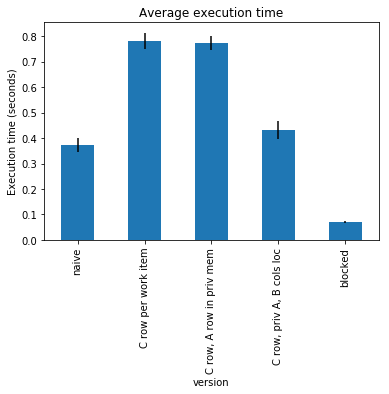

In [14]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df.groupby(by="version", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std);
plt.set_title("Average execution time");
plt.set_ylabel("Execution time (seconds)");
plt.get_figure().savefig("results.pdf")

# Referências

* [Hands On OpenCL](http://handsonopencl.github.io/)